## CNN

* https://paper.dropbox.com/doc/CNN-ZJvbCzAnDTYe71NH60HRI

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

## Dataset

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])


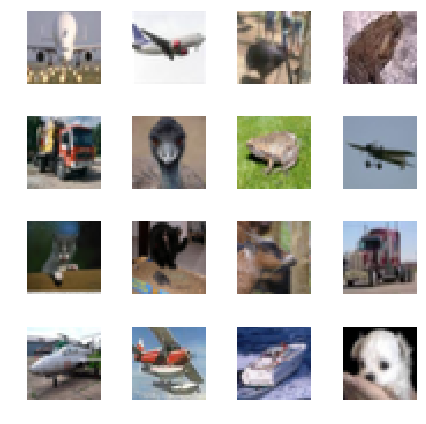

In [2]:
# CIFAR
train_loader, test_loader, classes = datasets.get_cifar_loader()
inputs,targets = next(iter(train_loader))
print(inputs.size())
utils.imgs.plot_rgb_samples(inputs)

## Im2col

* https://github.com/wiseodd/hipsternet/blob/master/hipsternet/im2col.py
* http://cs231n.github.io/convolutional-networks/#convert
* Convert a sliding window convolution into a single matrix multiplication by stretching out the filter

In [3]:
from utils.im2col import *


## Weight Initialization

* https://isaacchanghau.github.io/2017/05/24/Weight-Initialization-in-Artificial-Neural-Networks/
* https://stats.stackexchange.com/questions/47590/what-are-good-initial-weights-in-a-neural-network

In [4]:
def gaussian_init(dims):
    # Values are draw from normal distribution with mean 0 and variance 1
    return np.random.randn(*dims)

def uniform_init(low=-0.05, high=0.05, dims=None):
    # Values are draw from range [low, high) with equal probability
    # Includes low, excludes high
    return np.random.uniform(low, high, dims)

def xavier_init(X):
    pass

## Convolution Layer

* https://wiseodd.github.io/techblog/2016/07/16/convnet-conv-layer/
* https://github.com/zishansami102/CNN-from-Scratch/blob/master/CIFAR-10/convnet.py
* https://github.com/dreamgonfly/cnn-from-scratch
* https://github.com/utkarshojha/cnn-from-scratch/blob/master/cnn.py
* https://github.com/wiseodd/hipsternet/blob/master/hipsternet/layer.py
* http://gluon.mxnet.io/chapter04_convolutional-neural-networks/cnn-scratch.html

In [5]:
def pad(inp, padding):
    bs,c,h,w = inp.shape
    pad_inp = np.zeros((bs, c, h+2*padding, w+2*padding))
    pad_inp[:,:,padding:h+padding,padding:w+padding] = inp
    return pad_inp

def convolve_batch(batch, kernels, bias, padding, stride):
    bs,c,h,w = batch.shape
    n_ks,kc,kh,kw = kernels.shape
    assert c == kc
    #print("Batch", batch.shape, "Filters", kernels.shape)
    out_h = (h - kh + 2*padding) // stride + 1
    out_w = (w - kw + 2*padding) // stride + 1
    out = np.zeros((bs, n_ks, out_h, out_w))
    batch = pad(batch, padding)
    #print("Out", out.shape)
    for inp_idx, inp in enumerate(batch):
        for k_idx, kernel in enumerate(kernels):
            out[inp_idx][k_idx] = convolve(inp, kernel, bias[k_idx], stride)
    return out
    
def convolve(inp, kernel, bias, stride):
    c,h,w = inp.shape
    kc,kh,kw = kernel.shape
    assert c == kc
    out_h = (h - kh) // stride + 1
    out_w = (w - kw) // stride + 1
    out = np.zeros((1, out_h, out_w))
    out_row = 0
    for row in range(0, h-kh+1, stride):
        out_col = 0
        for col in range(0, w-kw+1, stride):
            for chan in range(c):
                # Elementwise multiply then sum for sliding window approach
                # Same as dot product of two flattened vectors
                dp = inp[chan, row:row+kh, col:col+kw] * kernel[chan]
                dp = np.sum(dp) + bias
                out[0, out_row, out_col] += dp
            out_col += 1
        out_row += 1
    out += bias
    return out / kc

In [6]:
inp = np.ones((1,3,5,5))
kernels = gaussian_init((2,3,3,3))
bias = np.zeros((2,1,1))
out = convolve_batch(inp, kernels, bias, padding=1, stride=2)
out.shape, out

((1, 2, 3, 3), array([[[[-1.02971349, -0.73272665, -0.36505776],
          [-0.45862458, -0.20197107, -0.19264232],
          [ 0.17351325,  0.30365725,  0.08291916]],
 
         [[-1.61401889, -1.576605  , -1.23378862],
          [-0.91320078, -1.51561402, -1.64549493],
          [ 0.05255324, -0.13107649,  0.36951972]]]]))

In [7]:
class Convolution():
    def __init__(self, in_chans, n_filters, fs=(3,3), 
                 stride=1, padding=1, init=gaussian_init):
        self.filters = init((n_filters, in_chans, fs[0], fs[1]))
        self.bias = np.zeros((n_filters, 1, 1, 1))
        self.stride = stride
        self.padding = padding
        
    def forward(self, X):
        return convolve_batch(X, self.filters, self.bias, self.padding, self.stride)
        
    def backward(self, X):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [8]:
conv = Convolution(in_chans=3, n_filters=2, fs=(3,3), stride=1, padding=1)
inp = np.ones((1,3,5,5))
conv(inp)

array([[[[ 1.2351347 ,  2.21446286,  2.21446286,  2.21446286,  1.24517747],
         [ 1.77035165,  2.62740373,  2.62740373,  2.62740373,  1.45478287],
         [ 1.77035165,  2.62740373,  2.62740373,  2.62740373,  1.45478287],
         [ 1.77035165,  2.62740373,  2.62740373,  2.62740373,  1.45478287],
         [ 1.19964137,  1.86806735,  1.86806735,  1.86806735,  0.69767028]],

        [[-0.13718542,  0.38532901,  0.38532901,  0.38532901, -0.37608671],
         [-0.27838391,  0.13033393,  0.13033393,  0.13033393,  0.19526163],
         [-0.27838391,  0.13033393,  0.13033393,  0.13033393,  0.19526163],
         [-0.27838391,  0.13033393,  0.13033393,  0.13033393,  0.19526163],
         [ 0.59541945,  1.33155393,  1.33155393,  1.33155393,  1.29821256]]]])

## MaxPooling Layer

In [9]:
def pool_batch(batch, ksize, stride):
    bs, c, h, w = batch.shape
    kh, kw = ksize
    out_h = (h - kh) // stride + 1
    out_w = (w - kw) // stride + 1
    out = np.zeros((bs, c, out_h, out_w))
    for idx, inp in enumerate(batch):
        out[idx,:,:,:] = pool(inp, ksize, stride)
    return out

def pool(inp, ksize, stride):
    c, h, w = inp.shape
    kh, kw = ksize
    out_h = (h - kh) // stride + 1
    out_w = (w - kw) // stride + 1
    out = np.zeros((c, out_h, out_w))
    out_row = 0
    for row in range(0, h-kh+1, stride):
        out_col = 0
        for col in range(0, w-kw+1, stride):
            out_pool = np.amax(inp[:, row:row+kh, col:col+kw], axis=(1,2))
            out[:, out_row, out_col] = out_pool
            out_col += 1
        out_row += 1
    return out

In [10]:
inp = gaussian_init((1,2,4,4))
ksize = (2,2)
stride = 2
out = pool_batch(inp, ksize, stride)
inp,out

(array([[[[ 1.69150184, -1.61065977, -2.06299158,  0.38602934],
          [-1.09915052, -0.21207344,  0.16046331,  1.03329293],
          [ 0.54166843, -0.47868855, -0.05523863,  1.1308245 ],
          [ 0.10545681, -1.64091953,  1.37605752, -0.22558802]],
 
         [[ 0.73920205,  0.8455005 ,  0.14064478, -1.19492216],
          [-0.61261798, -1.11830384,  1.02200147,  2.15960497],
          [ 0.90227844, -0.13935678,  0.75209634,  0.72413848],
          [-1.40283324,  0.6161536 , -0.6033981 , -0.83096746]]]]),
 array([[[[ 1.69150184,  1.03329293],
          [ 0.54166843,  1.37605752]],
 
         [[ 0.8455005 ,  2.15960497],
          [ 0.90227844,  0.75209634]]]]))

In [11]:
class MaxPool():
    def __init__(self, ksize=(2,2), stride=2):
        self.ksize = ksize
        self.stride = stride
    
    def forward(self, X):
        return pool_batch(X, self.ksize, self.stride)
    
    def backward(self, X):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [12]:
maxpool = MaxPool(ksize=(2,2), stride=2)
inp = gaussian_init((2,2,4,4))
maxpool(inp)

array([[[[ 1.94588675,  0.76246112],
         [ 1.66889623,  0.35658484]],

        [[ 1.41243001,  0.70687773],
         [ 0.75727178,  0.17290826]]],


       [[[ 1.26534723,  1.0138486 ],
         [-0.33496567,  1.60003648]],

        [[ 0.28751902,  1.1086362 ],
         [ 1.63040223,  0.16703517]]]])

## Activation Layer

In [13]:
class ReLU():
    def __init__(self):
        pass
    
    def forward(self, X):
        return np.maximum(0, X)
    
    def backward(self, X):
        X = X.copy()
        X[X < 0] = 0
        X[X > 0] = 1
        return Z
    
    def __call__(self, X):
        return self.forward(X)

class Sigmoid():
    def __init__(self):
        pass
    
    def forward(self, X):
        return self._sigmoid(X)
    
    def backward(self, X):
        return self._sigmoid(X) * (1 - self._sigmoid(X))
        
    def _sigmoid(self, X):
        return 1.0 / (1 + np.exp(-X))
    
    def __call__(self, X):
        return self.forward(X)

In [14]:
inp = gaussian_init((2,2,4,4))
relu = ReLU()
relu(inp)

array([[[[ 0.        ,  0.7646225 ,  0.        ,  0.        ],
         [ 0.11122354,  1.9446208 ,  0.16623505,  0.        ],
         [ 0.        ,  0.        ,  0.40051674,  0.26057261],
         [ 0.        ,  1.05733995,  0.        ,  1.41277959]],

        [[ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.04887454],
         [ 1.17267351,  0.        ,  0.55080441,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.00953042]]],


       [[[ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.14174331,  0.44242313,  0.        ,  0.        ],
         [ 1.10693593,  0.        ,  1.43803713,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.43450966]],

        [[ 1.68473125,  0.        ,  0.84330448,  0.02088047],
         [ 0.20389842,  2.05360342,  0.        ,  0.        ],
         [ 0.        ,  0.57711266,  0.67048142,  0.67116682],
         [ 0.        ,  0.        ,  1.18066409

In [15]:
inp = gaussian_init((2,2,4,4))
sigmoid = Sigmoid()
sigmoid(inp)

array([[[[ 0.34124471,  0.2054425 ,  0.78968972,  0.64818651],
         [ 0.72025629,  0.71453485,  0.2459434 ,  0.09880651],
         [ 0.27252502,  0.7489841 ,  0.49425241,  0.20889628],
         [ 0.37323192,  0.26163554,  0.77093893,  0.10832189]],

        [[ 0.27717473,  0.61985609,  0.56829928,  0.42771512],
         [ 0.64784032,  0.47312645,  0.81004681,  0.59806728],
         [ 0.45697978,  0.6103932 ,  0.83898752,  0.61623558],
         [ 0.7780959 ,  0.19247601,  0.32782437,  0.35497166]]],


       [[[ 0.24280275,  0.28766545,  0.18961469,  0.20190553],
         [ 0.59227421,  0.47896715,  0.53517833,  0.21528811],
         [ 0.51984067,  0.36301116,  0.38972944,  0.25798924],
         [ 0.58835532,  0.33210147,  0.7180696 ,  0.64697285]],

        [[ 0.46651482,  0.36867794,  0.54795235,  0.75839626],
         [ 0.39864555,  0.44470861,  0.32665693,  0.21374145],
         [ 0.67584216,  0.33562626,  0.40054868,  0.67206399],
         [ 0.17721194,  0.59934631,  0.66005665

## Dropout

* Binomial distribution vs Gaussian
* Gaussian = continuous centered around mean
    - Example: Height of a person
* Binomial = discrete, yes/no distribution, with p probabilty, over n trials
    - Example: Rolling a 6-sided die, 10 times (p=1/6, n=10)

In [162]:
def dropout(inp, p=0.05):
    # p: probability of dropout
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.binomial.html
    # https://en.wikipedia.org/wiki/Binomial_distribution
    # Binomial distribution - probability of yes/no for n trials
    mask = np.random.binomial(n=1, p=1-p, size=inp.shape)
    return mask * inp

In [167]:
class Dropout():
    def __init__(self, p=0.05):
        self.p = p
    
    def forward(self, X):
        return dropout(X, self.p)
    
    def backward(self, X):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [168]:
drop = Dropout(p=0.05)
inp = gaussian_init((2,2,4,4))
drop(inp)

array([[[[-0.2621779 , -0.01557268,  0.06400643, -0.19645577],
         [ 2.34699334, -1.44523469,  0.12383199, -0.57424097],
         [ 1.35646639, -1.42540477,  0.20494763,  0.5055195 ],
         [ 0.95479925,  0.48462461,  1.06121323,  0.01741106]],

        [[-1.80154262, -1.08725681,  1.1266869 , -0.1750599 ],
         [ 0.80561772,  0.        , -0.70402792, -1.22603202],
         [ 2.4875934 , -0.01252759, -1.30867758,  0.56352847],
         [ 0.97696247, -1.24174418,  0.39113505,  0.26818185]]],


       [[[-1.06256024, -0.09101791, -0.49852513, -0.30612782],
         [ 0.75404697,  0.97881261,  0.12199714,  0.56755911],
         [ 0.93746653, -2.26513413,  3.32104298, -0.14157961],
         [ 1.1783692 , -0.51377686, -1.71697481, -0.87493674]],

        [[-1.15527994,  0.80528469, -0.73739541,  1.03686186],
         [ 1.6108538 ,  1.22745192, -1.24406794, -0.40645834],
         [-0.4000521 , -0.95798658,  0.6089558 , -0.79753387],
         [-2.07797448, -0.44466001, -0.50590843

## Batch Norm

In [174]:
class BatchNorm():
    def __init__(self):
        pass
    
    def forward(self, X):
        return X
    
    def backward(self, X):
        return X
    
    def __call__(self, X):
        return self.forward(X)

## Linear

In [169]:
def flatten(X):
    bs = X.shape[0]
    return X.reshape((bs,-1))

In [170]:
class Linear():
    def __init__(self, in_feats, out_feats, init=uniform_init):
        self.weights = init(dims=(in_feats, out_feats))
        self.bias = np.array([1.0])
        self.out_feats = out_feats
    
    def forward(self, X):
        assert len(X.shape) == 2
        return X @ self.weights + self.bias
        
    def backward(self, X):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [171]:
inp = np.random.randn(1,128)
linear = Linear(in_feats=128, out_feats=12)
linear(inp)

array([[ 1.91176861,  0.90697328,  1.0353627 ,  1.40701311,  0.9904574 ,
         0.97519706,  0.9024867 ,  0.55283544,  0.75597021,  0.57529936,
         0.98345166,  0.88789012]])

## Model

In [192]:
class CNN():
    def __init__(self, input_dims):
        c,h,w = input_dims
        self.conv = Convolution(in_chans=c, n_filters=3, stride=1, padding=1)
        self.relu = ReLU()
        self.dropout = Dropout(p=0.05)
        self.maxpool = MaxPool(ksize=(2,2), stride=2)
        self.linear = Linear(in_feats=(h//2) * (w//2) * 3, out_feats=12)
        self.sigmoid = Sigmoid()
    
    def forward(self, X):
        out = self.conv(X)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.maxpool(out)
        out = flatten(out)
        out = self.linear(out)
        out = self.sigmoid(out)
        return out
    
    def backward(self, loss_func, X, y):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [193]:
inp = np.random.randn(1,3,8,8)
model = CNN(input_dims=(3,8,8))
model(inp)

array([[ 0.72400724,  0.68554862,  0.76920333,  0.65670069,  0.73330341,
         0.71047407,  0.7726815 ,  0.84372286,  0.86065683,  0.74935763,
         0.730531  ,  0.82109214]])

## Loss Function

* https://www.ics.uci.edu/~pjsadows/notes.pdf
* https://deepnotes.io/softmax-crossentropy

In [186]:
def cross_entropy(preds, targs):
    '''
    BCE: -(targs*log(preds) + (1-targs)*log(1-preds)) / len(preds)
    '''
    # Take the error when label=1
    cost1 = -targs * np.log(preds)

    # Take the error when label=0
    cost0 = (1 - targs) * np.log(1 - preds)

    #Take the sum of both costs
    cost = cost1 - cost0

    #Take the average cost
    cost = cost.sum() / len(preds)

    return cost

class CrossEntropy():
    def __init__(self):
        pass
    
    def forward(self, preds, targs):
        return cross_entropy(preds, targs)
    
    def backward(self, preds, targs):
        return preds - targs
    
    def __call__(self, preds, targs):
        return self.forward(preds, targs)

In [189]:
preds = np.array([.1, .9, .1])
targs = np.array([0, 1, 0])
bce = CrossEntropy()
bce(preds, targs)

0.10536051565782628

## SGD

In [190]:
def SGD(data, batch_size, lr):
    N = len(data)
    np.random.shuffle(data)
    mini_batches = np.array([data[i:i+batch_size] for i in range(0, N, batch_size)])
    for X,y in mini_batches:
        backprop(X, y, lr)

## Train

In [191]:
def train(model, inputs, targs, loss_func):
    
    for inp,targ in zip(inputs,targs):
    
        preds = model(inputs)

        loss = loss_func(preds, targs)

        model.backward(loss, preds, targs)    

## PyTorch

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_shape, n_classes):
        super().__init__()
        c,w,h = in_shape
        n_pool = 3
        w = int(w / 2**n_pool)
        h = int(h / 2**n_pool)
        self.features = nn.Sequential(
            nn.Conv2d(c, 8, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*w*h, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Train

In [ ]:
model = CNN(in_shape=(3,32,32), n_classes=10).cuda()

In [ ]:
inputs,targets = next(iter(train_loader))
output = model(Variable(inputs.cuda()))
output.size()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
lr_adjuster = learning_rates.FixedLR(initial_lr=1e-3, iteration_type='epoch')
trainer = training.QuickTrainer()
trainer.run(model, train_loader, test_loader, criterion, optimizer, epochs=10)

In [ ]:
plt.plot(np.stack([trainer.metrics['loss']['trn'], trainer.metrics['loss']['tst']], 1))

## Sources

* https://github.com/bfortuner/ml-study/blob/master/NeuralNetworkReLU.ipynb
* https://wiseodd.github.io/techblog/2016/07/16/convnet-conv-layer/
* http://cs231n.github.io/convolutional-networks/